# EVAC Assessment 1 - Evolve a Player for the Video Game Snake


In [1]:
import numpy as np
import logging
import os
from deap import tools
import warnings
%matplotlib inline

from game import DisplayGame, Snake, run_game
from network import NeuralNetwork, generate_neural_net
from genetic import genetic_algorithm
from visualisation import plot_cxindpb_experiment, plot_input_experiment, plot_final_algorithm

In [2]:
warnings.filterwarnings("ignore")

XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)
HEADLESS = True # True to run without graphical interface or False to run with the game showing
logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE) # Initializes display if not running in headless mode

# Initializes game
snake_game = Snake(XSIZE,YSIZE)
analysis_gen_number = 150
analysis_population_size = 1500
final_gen_number = 250
final_population_size = 1500

In [3]:
def run_cxindpb_experiment(gen_number, population_size, type):
    # Initializes neural network
    numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes = 10, 8, 8, 4
    network = NeuralNetwork(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)
    # Calculates the size of the individual using input, output and hidden layer neuron counts (accounting for bias nodes for hidden layers)
    ind_size = ((numInputNodes+1) * numHiddenNodes1) + ((numHiddenNodes1+1) * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)
    
    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//cx-indpb-{type}-experiment"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return

    if type == "exploration":
        iteration_num = 5
        indpb_probs = np.arange(0.003, 0.021, 0.006)
        cx_probs = np.arange(0.1, 0.5, 0.1)
        probability_pairs = [(indpb, cx) for indpb in indpb_probs for cx in cx_probs]
    elif type == "final":
        iteration_num = 15
        probability_pairs = [(0.021, 0.3), (0.015, 0.3)]

    count = 1
    logging.info(f"STARTING CX-INDPB {type.upper()} EXPERIMENT")
    for iteration in range(1, iteration_num + 1):
        for indpb, cx in probability_pairs:
            logging.info(f"Running algorithm for indpb {indpb} and cx {cx} - iteration {iteration}/{iteration_num} - overall completion {count}/{len(probability_pairs) * iteration_num}")
            genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size, mut_prob=indpb, cx_prob=cx, exp_type=f"cx-indpb-{type}")
            logging.info("> Run complete")
            count += 1
    logging.info(f"CX-INDPB {type.upper()} EXPERIMENT COMPLETE")

def run_input_experiment(gen_number, population_size, type):
    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//input-{type}-experiment"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return
    
    if type == "exploration":
        iteration_num = 5
        algorithms = ["a", "b", "c", "d", "e", "f", "g", "h"]
    elif type == "final":
        iteration_num = 15
        algorithms = ["b", "d"]
    
    count = 1
    logging.info(f"STARTING INPUT {type.upper()} EXPERIMENT")
    for iteration in range(1, iteration_num + 1):
        for algorithm in algorithms:
            ind_size, network = generate_neural_net(algorithm)
            logging.info(f"Running algorithm {algorithm.upper()} - iteration {iteration}/{iteration_num} - overall completion {count}/{len(algorithms) * iteration_num}")
            genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size,  mut_prob=0.021, cx_prob=0.3, exp_type=f"input-{type}", algorithm=algorithm)
            logging.info("> Run complete")
            count += 1
    logging.info(f"INPUT {type.upper()} EXPERIMENT COMPLETE")

def run_final_algorithm(gen_number, population_size):
    algorithm = "b"
    mutation_prob = 0.021
    crossover_prob = 0.3
    iteration_num = 15

    # Deletes existing folder and old run info
    save_loc = f"sim-outputs//final-algorithm"
    if os.path.exists(save_loc):
        logging.info("Found old folder for experiment - please save or delete")
        return
    
    count = 1
    logging.info(f"RUNNING FINAL ALGORITHM")
    for iteration in range(1, iteration_num + 1):
        ind_size, network = generate_neural_net(algorithm)
        logging.info(f"Running final algorithm - iteration {iteration}/{iteration_num}")
        genetic_algorithm(ind_size, network, snake_game, display, HEADLESS, gen_number, population_size,  mut_prob=mutation_prob, cx_prob=crossover_prob, exp_type=f"final-algorithm", algorithm=algorithm)
        logging.info("> Run complete")
        count += 1
    logging.info(f"FINISHED RUNNING FINAL ALGORITHM")


def run_test_experiment(algorithm, gen_num, pop_num):
    ind_size, network = generate_neural_net(algorithm)
    logbook = genetic_algorithm(ind_size, network, snake_game, display, HEADLESS,  gen_num, pop_num, exp_type="test", algorithm=algorithm)


In [4]:
def run_best_ind(pop_file, algorithm): # Loads best individual and runs in non-headless
    display = DisplayGame(XSIZE,YSIZE)
    _, network = generate_neural_net(algorithm)

    open_file = open(pop_file, "rb")
    population = pickle.load(open_file)
    open_file.close()

    bestInd = tools.selBest(population, 1)[0] 
    network.setWeightsLinear(bestInd)
    run_game(display, snake_game, False, network)

In [5]:
run_cxindpb_experiment(analysis_gen_number, analysis_population_size, "exploration")
run_cxindpb_experiment(analysis_gen_number, analysis_population_size, "final")

In [6]:
plot_cxindpb_experiment("exploration")
plot_cxindpb_experiment("final")

In [7]:
run_input_experiment(analysis_gen_number, analysis_population_size, "exploration")
run_input_experiment(analysis_gen_number, analysis_population_size, "final")

In [8]:
plot_input_experiment("exploration")
plot_input_experiment("final")

INFO:root:Found old folder for experiment - please save or delete


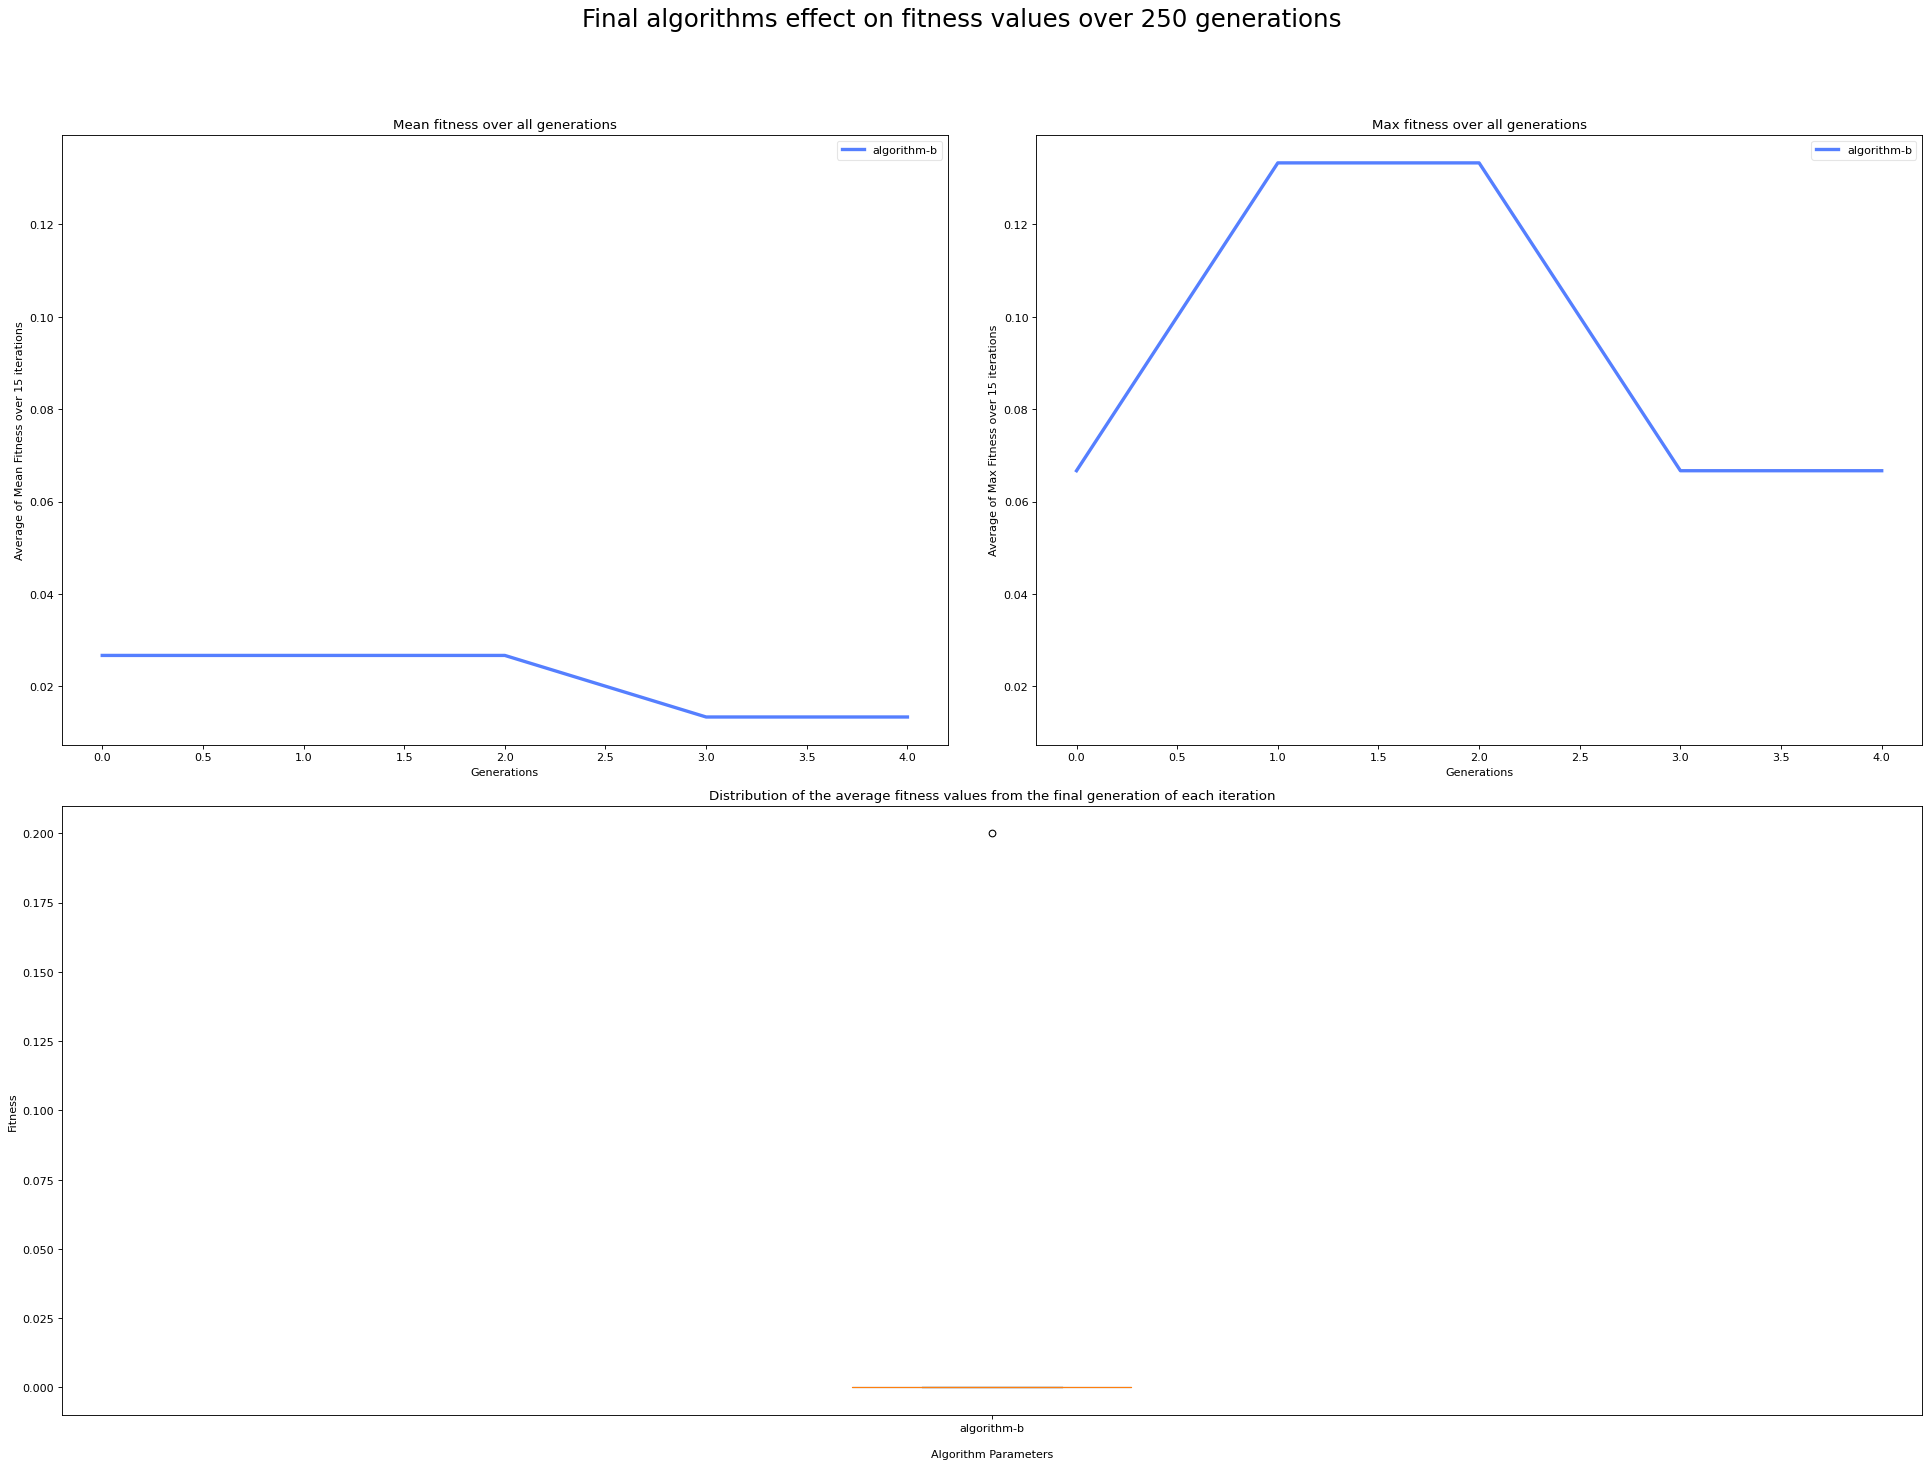

In [9]:
run_final_algorithm(final_gen_number, final_population_size)
plot_final_algorithm()